In [1]:
# import libraries

import numpy as np
import pandas as pd

np.random.seed(42)

In [2]:
import datetime as dt
# import yfinance as yf

# ativos = pd.read_csv("../data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('../data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('../data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[(prices.index <= dt.datetime(2023, 12, 30))]

indicadores = indicadores[(indicadores.index >= dt.datetime(2017, 1, 1)) & (indicadores.index <= dt.datetime(2023, 12, 31))]

In [3]:
limite_superior = 75
limite_inferior = 25

# Treino = Resto dos dados
# CV = 1 ano
# Teste = 1 ano

# K-fold = 2021, 2022, 2023

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [4]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados


True


In [5]:
# Começa a rebalancear no primeiro dia
indicadores_sinal.iloc[0, 1] = 1

In [6]:
import riskfolio as rp
import pandas as pd

constraints = pd.read_excel('./constraints.xlsx')
assets = pd.read_csv('./assets.csv')

# Função para obter os dias úteis
def get_business_days(prices, days=15):
    start_date = prices.index[0]
    end_date = prices.index[-1]
    
    # Lista para armazenar as datas
    dates = []
    current_date = start_date
    
    while current_date <= end_date:
        # Se a data atual não for dia útil, ajusta para o próximo dia útil
        if current_date.weekday() >= 5:  # Sábado (5) ou domingo (6)
            current_date += pd.offsets.BDay()
        
        # Adiciona a data ajustada à lista
        dates.append(current_date)
        
        current_date += pd.DateOffset(days=days)
    
    # Cria uma Series com essas datas como índice e valores True
    rebalancear = pd.Series(index=dates, data=True)
    rebalancear = rebalancear.reindex(prices.index, fill_value=False)
    
    return rebalancear


def optimization(prices, data, constraints=constraints, assets=assets):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    A, B = rp.assets_constraints(constraints, assets)

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y, ainequality=A, binequality=B)

    method_mu = 'hist'
    method_cov = 'hist'  # hist, ledoit, ewma (suavização exponencial)

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)


# prices.sort_index(inplace=True)
# prices_limite = prices[(get_business_days(prices)) & (prices.index >= dt.datetime(2017, 1, 1))]

# pesos_dias = pd.DataFrame()
# for data, entry in prices_limite.iterrows():
#     w = optimization(prices, data).T
#     w.index = [data]
#     pesos_dias = pd.concat([pesos_dias, w], axis=0)

# pesos_dias.to_csv('../data/pesos/pesos_dias3.csv')
# pesos_dias
pesos_dias = pd.read_csv('../data/pesos/pesos_dias2.csv', index_col='Date', parse_dates=True)
pesos_dias

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.073608,2.441002e-02,3.188716e-10,7.812301e-10,5.843060e-10,1.637019e-02,4.360706e-10,2.355390e-02,3.776281e-03,8.747818e-10,...,0.043801,2.465294e-09,1.915178e-09,0.045005,2.484488e-02,5.449659e-10,5.321893e-10,6.822161e-09,3.250263e-05,1.559840e-09
2017-01-19,0.069645,2.627061e-02,5.366055e-11,1.217621e-10,8.918987e-11,2.163558e-02,6.542762e-11,1.874722e-02,4.745009e-03,1.487617e-10,...,0.038524,3.193758e-10,2.693671e-10,0.042573,3.135784e-02,7.633273e-11,7.882633e-11,1.469002e-08,4.375315e-10,1.908113e-10
2017-02-03,0.085573,3.397254e-02,1.235786e-10,2.993180e-10,2.161553e-10,3.214453e-02,1.490102e-10,3.474210e-02,8.070821e-03,2.973732e-10,...,0.042193,1.726788e-09,7.080951e-10,0.055175,3.804522e-02,1.728316e-10,1.826169e-10,9.763507e-04,4.592375e-09,4.820536e-10
2017-02-20,0.084158,2.970024e-02,4.067948e-11,9.924295e-11,7.013947e-11,2.951461e-02,4.886971e-11,2.986113e-02,1.013497e-02,9.645780e-11,...,0.043147,5.313431e-10,2.080010e-10,0.050959,3.755679e-02,6.049317e-11,6.014688e-11,5.337348e-09,1.939099e-09,1.600376e-10
2017-03-07,0.078351,2.834526e-02,4.979111e-10,1.269555e-09,8.778515e-10,2.854260e-02,5.953758e-10,3.049769e-02,9.348583e-03,1.188327e-09,...,0.043550,5.707833e-09,2.883196e-09,0.049272,3.993522e-02,6.706799e-10,7.312514e-10,1.248740e-04,9.955405e-09,2.330854e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,0.125990,5.147013e-10,1.915422e-09,4.122076e-09,2.377682e-09,1.845127e-08,7.941804e-09,3.557265e-10,9.910767e-10,9.769438e-10,...,0.210739,1.980590e-02,5.518979e-10,0.209722,4.259385e-10,4.372887e-10,5.778644e-02,7.428027e-02,1.385997e-07,2.833530e-10
2023-11-03,0.136776,3.193369e-10,1.367784e-09,2.567578e-09,1.621464e-09,2.220198e-08,3.626261e-09,2.290480e-10,4.943400e-10,6.871369e-10,...,0.227278,2.726101e-02,3.147947e-10,0.163957,2.818713e-10,3.042990e-10,5.949412e-02,6.607203e-02,4.082841e-09,1.796456e-10
2023-11-20,0.145970,7.816889e-11,3.498668e-10,1.020653e-09,5.118960e-10,4.693537e-09,7.012499e-10,5.239785e-11,1.279694e-10,1.635300e-10,...,0.246550,3.946321e-02,7.499239e-11,0.132247,6.982824e-11,6.873461e-11,5.303838e-02,7.517984e-02,2.245072e-09,4.718413e-11


In [7]:
import riskfolio as rp
import pandas as pd
import matplotlib.pyplot as plt

# Constraints da otimização
# Restrições:
# - No max 30% em um ativo
# - No min 5% em um ativo para entrar na carteira
# - Usar estudo do artigo

graficos = True

constraints = pd.read_excel('./constraints.xlsx')
assets = pd.read_csv('./assets.csv')

def optimization(prices, data, constraints=constraints, assets=assets):
    global graficos
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    A, B = rp.assets_constraints(constraints, assets)

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y, ainequality=A, binequality=B)

    method_mu = 'hist'
    method_cov = 'hist'  # hist, ledoit, ewma (suavização exponencial)

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2017-01-02,7.278613e-02,2.472937e-02,1.276057e-10,3.104875e-10,2.313766e-10,1.642797e-02,1.668919e-10,2.261470e-02,4.214374e-03,3.429583e-10,...,0.043390,9.289784e-10,7.745284e-10,0.044644,2.412963e-02,2.079644e-10,2.007634e-10,1.342544e-09,1.302813e-03,5.706804e-10
2017-05-19,8.516365e-02,2.435881e-02,5.646600e-11,1.209320e-10,9.685884e-11,5.587130e-02,6.844628e-11,1.649536e-02,1.367100e-02,1.123889e-10,...,0.036966,5.615832e-10,4.134396e-10,0.039839,3.938025e-02,6.052165e-11,8.910895e-11,5.431492e-10,2.896338e-09,1.977905e-10
2018-06-08,1.704264e-01,8.725424e-09,1.175765e-10,2.492002e-10,2.497673e-10,7.758542e-02,2.106421e-10,3.237807e-10,3.410382e-03,2.673844e-10,...,0.030980,4.676548e-10,2.442517e-02,0.111293,2.371742e-02,1.153671e-10,4.745144e-10,2.144084e-02,6.712608e-10,1.928693e-10
2018-08-14,1.391093e-01,4.702009e-03,2.691612e-10,4.998287e-10,5.010616e-10,6.434524e-02,5.076403e-10,1.031732e-09,2.378385e-02,6.528997e-10,...,0.032260,1.216072e-09,3.479079e-02,0.088193,2.032728e-02,2.385080e-10,1.865234e-09,2.926890e-02,1.513367e-09,3.831275e-10
2018-08-24,1.396413e-01,3.560356e-03,1.895729e-10,3.492817e-10,3.535298e-10,6.040617e-02,3.645728e-10,7.081339e-10,2.365809e-02,4.485182e-10,...,0.031886,8.005312e-10,3.720469e-02,0.094347,2.003713e-02,1.713580e-10,1.273963e-09,2.900376e-02,1.091527e-09,2.621657e-10
2018-08-29,1.389829e-01,3.160433e-03,2.712487e-10,4.934284e-10,4.968687e-10,6.086963e-02,5.074938e-10,9.604072e-10,2.443450e-02,6.223786e-10,...,0.032941,1.090813e-09,3.586138e-02,0.093710,1.951048e-02,2.371508e-10,1.723795e-09,2.896481e-02,1.573404e-09,3.731830e-10
2018-09-04,1.425661e-01,6.067750e-08,1.833574e-10,3.340010e-10,3.327434e-10,6.305161e-02,3.462949e-10,6.549437e-10,2.375179e-02,4.557628e-10,...,0.034957,7.220604e-10,3.773130e-02,0.088614,1.010122e-02,1.658770e-10,1.339197e-09,3.047499e-02,1.140232e-09,2.427684e-10
2018-09-11,1.390463e-01,3.169913e-08,4.412230e-10,8.074914e-10,8.086816e-10,6.245651e-02,9.047605e-10,1.602503e-09,2.383035e-02,1.145531e-09,...,0.038854,1.984343e-09,3.972278e-02,0.093210,1.276678e-02,4.025035e-10,4.562514e-09,3.330976e-02,2.980286e-09,5.934138e-10
2020-01-15,5.934059e-02,2.601962e-03,3.023288e-10,3.710740e-10,5.366525e-10,2.691606e-08,7.369495e-10,5.890332e-09,1.555940e-02,9.484269e-10,...,0.026322,9.696714e-10,3.716912e-02,0.101670,4.427358e-10,2.195737e-10,3.400850e-02,8.528119e-02,3.815919e-03,2.766642e-10
2020-03-16,1.765153e-02,9.541470e-11,5.803300e-11,7.195282e-11,8.960495e-11,8.538553e-11,1.000614e-10,9.194349e-11,6.645084e-11,5.385481e-11,...,0.270221,3.174869e-10,1.985050e-10,0.174643,4.270605e-11,5.856496e-11,1.124142e-10,1.402548e-01,1.563790e-10,9.920019e-11


c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


<Axes: title={'center': 'Equity Progression'}>

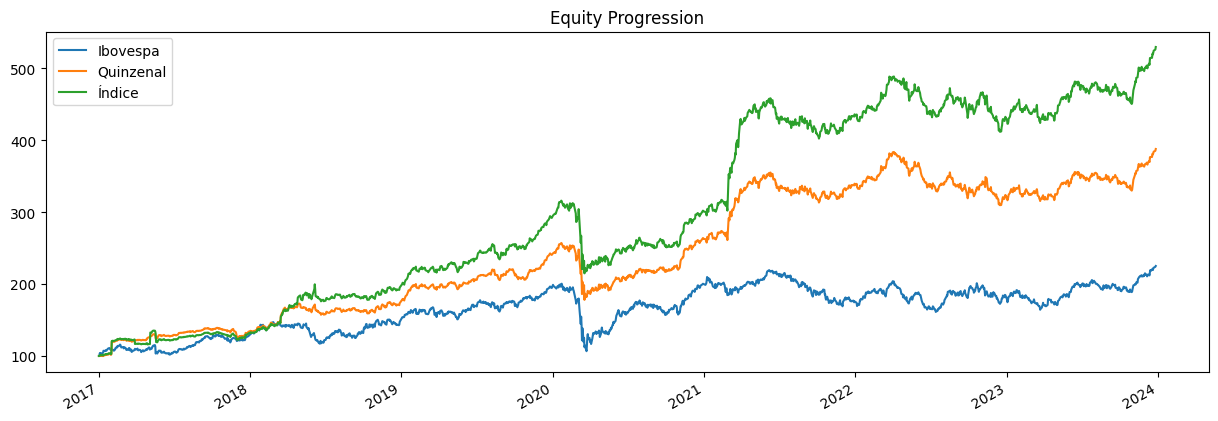

In [8]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Medir turnover (o quanto seus pesos mudam ao longo do tempo)

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia CVM X/dias
strat_cvm_dias = bt.Strategy('Quinzenal', [
    bt.algos.WeighTarget(pesos_dias),
    bt.algos.Rebalance()
])


# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Índice', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])

# Criando o backtest
backtests = [
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    # bt.Backtest(strat_buy_hold, prices, initial_capital=1000000000),
    bt.Backtest(strat_cvm_dias, prices, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000),
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [9]:
# Resultados
results.display()

Stat                 Ibovespa    Quinzenal    Índice
-------------------  ----------  -----------  ----------
Start                2017-01-01  2017-01-01   2017-01-01
End                  2023-12-27  2023-12-27   2023-12-27
Risk-free rate       0.00%       0.00%        0.00%

Total Return         125.19%     287.98%      429.87%
Daily Sharpe         0.60        1.16         1.28
Daily Sortino        0.92        1.98         2.23
CAGR                 12.33%      21.42%       26.97%
Max Drawdown         -46.81%     -30.76%      -31.99%
Calmar Ratio         0.26        0.70         0.84

MTD                  5.39%       6.14%        6.13%
3m                   17.38%      14.32%       14.70%
6m                   14.19%      10.95%       12.02%
YTD                  21.96%      19.75%       22.45%
1Y                   23.86%      21.65%       24.11%
3Y (ann.)            4.08%       13.82%       20.73%
5Y (ann.)            9.45%       17.85%       22.52%
10Y (ann.)           -           -    

In [10]:
trans = results.get_transactions("Índice")
trans

price   quantity
Date       Security                       
2017-01-02 ABEV3.SA   12.610022  5772085.0
           ALPA4.SA    7.343465  3367534.0
           BEEF3.SA    9.014328  1822429.0
           BRFS3.SA   45.596249   495977.0
           BRKM5.SA   25.145233   167601.0
...                         ...        ...
2023-12-14 TAEE11.SA  34.128864  2607773.0
           TIMS3.SA   17.333979 -2355317.0
           TRPL4.SA   23.760000 -3351248.0
           VALE3.SA   67.781174   397952.0
           VIVT3.SA   51.650356  -195417.0

[376 rows x 2 columns]

In [11]:
# Ver resultados
# Escolher dados para analisar
# Analisar os dados
# Tirar insights
# Fazer comparação com o Ibovespa
# Analisar por período - (Quais anos foram melhores ou piores) e entender o porquê

dir(results['Índice'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate',
 '_create_stats_series',
 '_end',
 '_get_default_plot_title',
 '_get_series',
 '_start',
 '_stats',
 '_update',
 'annualization_factor',
 'avg_down_month',
 'avg_drawdown',
 'avg_drawdown_days',
 'avg_up_month',
 'best_day',
 'best_month',
 'best_year',
 'cagr',
 'calmar',
 'daily_kurt',
 'daily_mean',
 'daily_prices',
 'daily_sharpe',
 'daily_skew',
 'daily_sortino',
 'daily_vol',
 'display',
 'display_lookback_returns',
 'display_monthly_returns',
 'drawdown',
 'drawdown_details',
 'end',
 'five_year',
 'incep',
 'log_returns',
 'lookback_returns',
 'max_drawdown',
 'monthly_kurt',
 'month

In [12]:
# 1 - Indicador com bandas dos limites
# 2 - Retornos com momentos de reotimização
# 3 - Ações mais negociadas/com maiores pesos

In [13]:
results['Índice'].return_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
2017,0.032072,0.195152,-0.051036,-0.008345,0.051687,0.009912,0.029332,0.017192,0.013567,-0.006032,-0.056383,0.072543,0.316155
2018,0.051675,0.025267,0.152959,0.122792,-0.014147,-0.024101,0.048431,-0.016219,-0.002949,0.016822,0.051383,0.004191,0.482608
2019,0.134689,-0.008755,0.002243,0.043770,0.005865,0.019238,0.049874,-0.012635,0.046517,-0.005451,0.077523,0.067149,0.496545
2020,0.048719,-0.063065,-0.210930,0.023038,0.045052,0.029229,0.048819,-0.039844,0.004723,0.000060,0.152424,0.036843,0.031492
2021,-0.001615,0.005103,0.406103,0.054161,0.002995,-0.052503,-0.020308,0.015547,-0.035465,0.005704,0.007908,0.053037,0.447944
2022,0.027611,0.000605,0.083687,-0.027199,-0.006490,-0.071744,0.019113,0.026029,-0.043845,0.069698,-0.074337,0.002484,-0.007887
2023,0.055823,-0.040267,-0.020636,0.020397,0.034823,0.051715,-0.001524,-0.016241,-0.001923,-0.033203,0.104507,0.061341,0.224526


In [14]:
results['Índice'].return_table.map('{:.2%}'.format)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
2017,3.21%,19.52%,-5.10%,-0.83%,5.17%,0.99%,2.93%,1.72%,1.36%,-0.60%,-5.64%,7.25%,31.62%
2018,5.17%,2.53%,15.30%,12.28%,-1.41%,-2.41%,4.84%,-1.62%,-0.29%,1.68%,5.14%,0.42%,48.26%
2019,13.47%,-0.88%,0.22%,4.38%,0.59%,1.92%,4.99%,-1.26%,4.65%,-0.55%,7.75%,6.71%,49.65%
2020,4.87%,-6.31%,-21.09%,2.30%,4.51%,2.92%,4.88%,-3.98%,0.47%,0.01%,15.24%,3.68%,3.15%
2021,-0.16%,0.51%,40.61%,5.42%,0.30%,-5.25%,-2.03%,1.55%,-3.55%,0.57%,0.79%,5.30%,44.79%
2022,2.76%,0.06%,8.37%,-2.72%,-0.65%,-7.17%,1.91%,2.60%,-4.38%,6.97%,-7.43%,0.25%,-0.79%
2023,5.58%,-4.03%,-2.06%,2.04%,3.48%,5.17%,-0.15%,-1.62%,-0.19%,-3.32%,10.45%,6.13%,22.45%


In [27]:
import plotly.graph_objects as go

retornos_anuais = results['Índice'].return_table['YTD']
retornos_ibov = results['Ibovespa'].return_table['YTD']
retornos_quinzenal = results['Quinzenal'].return_table['YTD']

# Criação da figura
fig = go.Figure()

# Adiciona uma barra para retornos anuais com cor personalizada
fig.add_trace(go.Bar(
    x=retornos_anuais.index,
    y=retornos_anuais,
    name='Emotiwand',
))

# Adiciona uma barra para retornos do Ibovespa com cor personalizada
fig.add_trace(go.Bar(
    x=retornos_ibov.index,
    y=retornos_ibov,
    name='Ibovespa',
))

# Adiciona uma barra para retornos quinzenais com cor personalizada
fig.add_trace(go.Bar(
    x=retornos_quinzenal.index,
    y=retornos_quinzenal,
    name='Quinzenal',
    marker=dict(color='orange')  # Cor personalizada
))

fig.update_layout(
    title='Retornos acumulados por ano',
    xaxis_title='Ativo',
    yaxis_title='Retorno acumulado no ano',
    barmode='group',  # Agrupa as barras lado a lado
    yaxis=dict(
        tickformat='.2%'  # Formata os rótulos como porcentagem com duas casas decimais
    ),
    margin=dict(l=0, r=0, t=50, b=0),
    legend=dict(title="Estratégias"),
)

# Exibe o gráfico
fig.show()

In [16]:
# 1 - Indicador com bandas dos limites
# 2 - Retornos com momentos de reotimização
# 3 - Ações mais negociadas/com maiores pesos

In [17]:
turnover = pesos.diff().abs().sum(axis=1)
turnover

2017-01-02    0.000000
2017-05-19    0.335171
2018-06-08    0.967527
2018-08-14    0.204634
2018-08-24    0.032468
2018-08-29    0.016977
2018-09-04    0.051043
2018-09-11    0.042570
2020-01-15    0.667701
2020-03-16    0.988772
2020-10-22    0.426385
2020-11-18    0.046055
2021-03-31    0.252607
2021-11-11    0.134105
2023-03-24    0.686048
2023-07-24    0.241126
2023-08-22    0.080832
2023-11-16    0.300152
2023-11-29    0.056328
2023-12-14    0.087078
dtype: float64

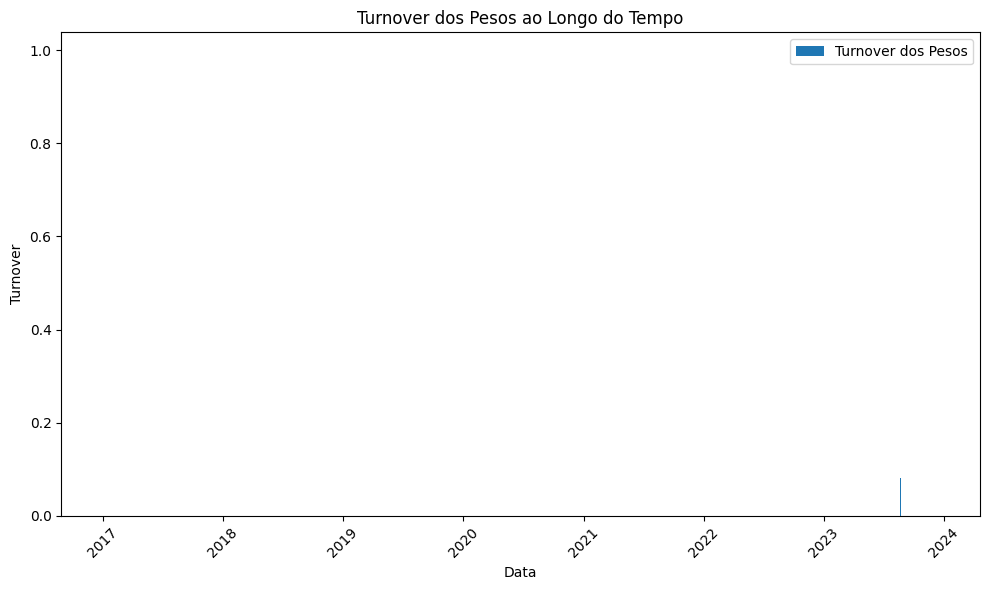

In [18]:
import matplotlib.pyplot as plt

# Calculando o turnover dos pesos
turnover = pesos.diff().abs().sum(axis=1)

# Plotando o turnover como um gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(turnover.index, turnover.values, label="Turnover dos Pesos")
plt.title("Turnover dos Pesos ao Longo do Tempo")
plt.ylabel("Turnover")
plt.xlabel("Data")
plt.legend()
plt.xticks(rotation=45)  # Rotaciona as datas no eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [19]:
top_assets = pesos.mean().nlargest(5).sort_values(ascending=False).index
top_assets

Index(['TAEE11.SA', 'TRPL4.SA', 'SUZB3.SA', 'ABEV3.SA', 'EGIE3.SA'], dtype='object')

In [20]:
import plotly.graph_objects as go

fig = go.Figure()

# Criar o gráfico de área empilhado para cada ativo em top_assets
for asset in top_assets:
    fig.add_trace(go.Scatter(
        x=pesos.index,
        y=pesos[asset],
        mode='lines',
        stackgroup='one',  # Define um grupo de empilhamento
        name=asset.rstrip('.SA')
    ))

# Configurar o layout
fig.update_layout(
    title='Pesos dos Principais Ativos ao Longo do Tempo',
    xaxis_title='Data',
    yaxis_title='Pesos',
    showlegend=True,
    height=500,
)

fig.show()

In [28]:
# Calcule a série cumulativa de retornos
cumulative_returns = (results['Índice'].returns + 1).cumprod() - 1
ibov_cumulative_returns = (results['Ibovespa'].returns + 1).cumprod() - 1
cvm_quinzenal_cumulative_returns = (results['Quinzenal'].returns + 1).cumprod() - 1
# buy_n_hold_cumulative_returns = (results['Buy&Hold'].returns + 1).cumprod() - 1

# Crie a figura
fig = go.Figure()

# Adicione a linha da curva cumulativa de retornos para cada série
fig.add_trace(go.Scatter(
    x=cumulative_returns.index,
    y=cumulative_returns.values,
    mode='lines',
    name='Emotiwand'
))

fig.add_trace(go.Scatter(
    x=ibov_cumulative_returns.index,
    y=ibov_cumulative_returns.values,
    mode='lines',
    name='Ibovespa'
))

fig.add_trace(go.Scatter(
    x=cvm_quinzenal_cumulative_returns.index,
    y=cvm_quinzenal_cumulative_returns.values,
    mode='lines',
    name='Quinzenal',
    line=dict(color='orange')  # Configura a cor da linha
))

# fig.add_trace(go.Scatter(
#     x=buy_n_hold_cumulative_returns.index,
#     y=buy_n_hold_cumulative_returns.values,
#     mode='lines',
#     name='Buy&Hold'
# ))

# Adicione os pontos onde a condição é atendida
signals_x = indicadores_sinal[indicadores_sinal[0] == 1].index
signals_y = cumulative_returns.loc[signals_x]

# Adicione os pontos de sinal no gráfico
fig.add_trace(go.Scatter(
    x=signals_x,
    y=signals_y,
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-down'),  # Configura o tamanho e o estilo
    name='Sinais'
))

# Exibe o gráfico
fig.update_layout(
    title="Retorno Cumulativo (Emotiwand vs Ibovespa vs CVM Quinzenal)",
    xaxis_title="Data",
    yaxis_title="Retorno Cumulativo",
    legend=dict(title="Carteiras"),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [22]:
import plotly.graph_objects as go
import yfinance as yf

ibov = yf.download('^BVSP', start='2017-01-01', end='2023-12-31')[['Adj Close']]

# TODO: Colocar um índice (IBOV) para comparar

# Definir os limites das bandas
upper_band = 75
lower_band = 25

# Criar a figura
fig = go.Figure()

# Adicionar a linha do indicador dentro das bandas (cinza)
fig.add_trace(go.Scatter(
    x=indicadores_sinal.index,
    y=indicadores_sinal['indicador'],
    mode='lines',
    line=dict(color='#636efa', width=1),
    name='Índice'
))

# Adicionar os pontos de sinal no gráfico
signals_x = indicadores_sinal[indicadores_sinal[0] == 1].index[1:]
signals_y = indicadores_sinal.loc[indicadores_sinal[0] == 1, 'indicador'][1:]

fig.add_trace(go.Scatter(
    x=signals_x,
    y=signals_y,
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-down'),
    name='Sinais'
))

# Adicionar as bandas como linhas horizontais
fig.add_shape(type="line", x0=indicadores_sinal.index.min(), x1=indicadores_sinal.index.max(),
              y0=upper_band, y1=upper_band, line=dict(color="green", dash="dash"), name="Banda Superior")

fig.add_shape(type="line", x0=indicadores_sinal.index.min(), x1=indicadores_sinal.index.max(),
              y0=lower_band, y1=lower_band, line=dict(color="green", dash="dash"), name="Banda Inferior")

fig.add_annotation(x=indicadores_sinal.index.min(), y=upper_band,
                   text="75", showarrow=False, yshift=10, font=dict(color="black", size=12))
fig.add_annotation(x=indicadores_sinal.index.min(), y=lower_band,
                   text="25", showarrow=False, yshift=-10, font=dict(color="black", size=12))

# Configurar o layout do gráfico com largura maior e margens menores
fig.update_layout(
    title='',
    xaxis_title="Data",
    yaxis_title="EmotiWand",
    legend=dict(title="Legenda"),
    width=1300,  # Define a largura maior
    margin=dict(l=0, r=0, t=50, b=0),  # Margens menores: left, right, top, bottom
    plot_bgcolor='white'  # Cor de fundo do gráfico
)
fig.update_yaxes(showgrid=False, showline=True, linewidth=2, linecolor='black')
fig.update_xaxes(showgrid=False, showline=True, linewidth=2, linecolor='black')

fig.show()

c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


In [23]:
import plotly.graph_objects as go
import yfinance as yf

# Baixar dados do IBOVESPA
ibov = yf.download('^BVSP', start='2017-01-01', end='2023-12-31')[['Adj Close']]

# TODO: Substituir por dados reais do indicador
upper_band = 75
lower_band = 25

# Criar a figura
fig = go.Figure()

# Adicionar a linha do indicador no eixo esquerdo
fig.add_trace(go.Scatter(
    x=indicadores_sinal.index,
    y=indicadores_sinal['indicador'],
    mode='lines',
    line=dict(color='#636efa', width=1),
    name='Índice'
))

# Adicionar os pontos de sinal no gráfico
signals_x = indicadores_sinal[indicadores_sinal[0] == 1].index[1:]
signals_y = indicadores_sinal.loc[indicadores_sinal[0] == 1, 'indicador'].iloc[1:]

fig.add_trace(go.Scatter(
    x=signals_x,
    y=signals_y,
    mode='markers',
    marker=dict(color='green', size=15, symbol='triangle-down'),
    name='Sinais'
))

# Adicionar as bandas como linhas horizontais
fig.add_hline(y=upper_band, line_dash="dash", line_color="black", name="Banda Superior")
fig.add_hline(y=lower_band, line_dash="dash", line_color="black", name="Banda Inferior")

fig.add_annotation(x=indicadores_sinal.index.min(), y=upper_band,
                   text="75", showarrow=False, yshift=10, font=dict(color="black", size=12))
fig.add_annotation(x=indicadores_sinal.index.min(), y=lower_band,
                   text="25", showarrow=False, yshift=-10, font=dict(color="black", size=12))

# Adicionar os preços do IBOV no eixo secundário (direito)
fig.add_trace(go.Scatter(
    x=ibov.index,
    y=ibov['Adj Close'],
    mode='lines',
    line=dict(color='#ef553b'),
    name='IBOV',
    yaxis='y2'  # Especifica o eixo secundário
))

# Configurar o layout com dois eixos Y
fig.update_layout(
    title='Comparação movimento do Índice Emotiwand e IBOVESPA com Sinais e Limites',
    xaxis=dict(title="Data"),
    yaxis=dict(title="Índice", range=[0, 100]),  # Eixo primário para o indicador
    yaxis2=dict(
        title="IBOV (Preço Ajustado)",
        overlaying='y',  # Sobrepõe o eixo primário
        side='right'  # Coloca o eixo no lado direito
    ),
    legend=dict(title="Legenda"),
    width=1300,  # Define a largura maior
    margin=dict(l=0, r=0, t=50, b=0)  # Margens menores: left, right, top, bottom
)

fig.show()

c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed
